# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = 'Scene1-LSTM3'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 300

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=10, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=10, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(9479, 9845)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([300, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([300, 6])

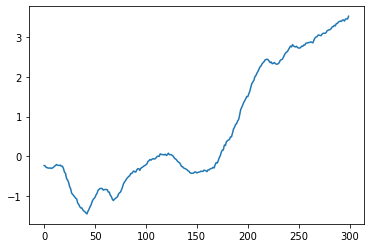

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.1,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [ ]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :  10.134701
 - Pitch        :  13.178530
 - Roll         :   3.076214
 - RMS          :   9.761299
 - 99% Tile     :  44.315270
Save output signals into checkpoint/Scene1-LSTM3/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.679790
 - Pitch        :  11.976026
 - Roll         :   3.076194
 - RMS          :   9.066173
 - 99% Tile     :  43.350306
Save output signals into checkpoint/Scene1-LSTM3/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.267272
 - Pitch        :   9.767348
 - Roll         :   3.078842
 - RMS          :   7.974181
 - 99% Tile     :  41.630175
Save output signals into checkpoint/Scene1-LSTM3/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.428640
 - Pitch        :   8.554751
 - Roll         :   3.075665
 - RMS          :   7.561807
 - 99% Tile     :  40.885505
Save output signals into checkpoint/Scene1-LSTM3/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.252507
 - Pitch        :   8.121109
 - Roll         :   3.077121
 - RMS          :   7.326436
 - 99% Tile     :  40.085327
Save output signals into checkpoint/Scene1-LSTM3/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.904537
 - Pitch        :   7.880840
 - Roll         :   3.085251
 - RMS          :   7.092653
 - 99% Tile     :  38.608913
Save output signals into checkpoint/Scene1-LSTM3/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.800371
 - Pitch        :   7.651722
 - Roll         :   3.033635
 - RMS          :   6.547203
 - 99% Tile     :  35.446667
Save output signals into checkpoint/Scene1-LSTM3/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.768521
 - Pitch        :   7.031278
 - Roll         :   3.009906
 - RMS          :   5.896646
 - 99% Tile     :  33.706443
Save output signals into checkpoint/Scene1-LSTM3/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.351358
 - Pitch        :   6.411970
 - Roll         :   2.956249
 - RMS          :   5.483080
 - 99% Tile     :  32.518867
Save output signals into checkpoint/Scene1-LSTM3/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.163642
 - Pitch        :   6.063777
 - Roll         :   2.978232
 - RMS          :   4.909259
 - 99% Tile     :  31.460301
Save output signals into checkpoint/Scene1-LSTM3/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.514955
 - Pitch        :   5.101905
 - Roll         :   2.906327
 - RMS          :   4.276330
 - 99% Tile     :  29.955204
Save output signals into checkpoint/Scene1-LSTM3/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.258432
 - Pitch        :   4.236983
 - Roll         :   2.898522
 - RMS          :   3.850874
 - 99% Tile     :  28.153988
Save output signals into checkpoint/Scene1-LSTM3/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.593245
 - Pitch        :   3.765848
 - Roll         :   2.839009
 - RMS          :   3.423107
 - 99% Tile     :  26.882285
Save output signals into checkpoint/Scene1-LSTM3/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.892602
 - Pitch        :   3.706392
 - Roll         :   2.842713
 - RMS          :   3.510494
 - 99% Tile     :  25.932114
Save output signals into checkpoint/Scene1-LSTM3/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.212590
 - Pitch        :   3.158855
 - Roll         :   2.824476
 - RMS          :   3.070112
 - 99% Tile     :  24.599120
Save output signals into checkpoint/Scene1-LSTM3/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.047837
 - Pitch        :   2.986294
 - Roll         :   2.841280
 - RMS          :   2.959737
 - 99% Tile     :  23.698993
Save output signals into checkpoint/Scene1-LSTM3/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.605320
 - Pitch        :   2.804129
 - Roll         :   2.809870
 - RMS          :   2.741423
 - 99% Tile     :  22.597639
Save output signals into checkpoint/Scene1-LSTM3/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.925373
 - Pitch        :   2.450547
 - Roll         :   2.810325
 - RMS          :   2.736233
 - 99% Tile     :  21.634963
Save output signals into checkpoint/Scene1-LSTM3/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.576255
 - Pitch        :   2.403716
 - Roll         :   2.818392
 - RMS          :   2.605013
 - 99% Tile     :  20.890946
Save output signals into checkpoint/Scene1-LSTM3/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.304913
 - Pitch        :   2.257539
 - Roll         :   2.798335
 - RMS          :   2.465751
 - 99% Tile     :  20.151484
Save output signals into checkpoint/Scene1-LSTM3/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.189343
 - Pitch        :   2.069457
 - Roll         :   2.751271
 - RMS          :   2.355516
 - 99% Tile     :  19.621080
Save output signals into checkpoint/Scene1-LSTM3/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.955446
 - Pitch        :   2.795811
 - Roll         :   2.804453
 - RMS          :   2.852846
 - 99% Tile     :  19.198879
Save output signals into checkpoint/Scene1-LSTM3/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.071022
 - Pitch        :   1.988069
 - Roll         :   2.752536
 - RMS          :   2.296229
 - 99% Tile     :  18.536030
Save output signals into checkpoint/Scene1-LSTM3/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.815569
 - Pitch        :   1.911059
 - Roll         :   2.457443
 - RMS          :   2.080662
 - 99% Tile     :  17.607284
Save output signals into checkpoint/Scene1-LSTM3/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.004130
 - Pitch        :   1.923433
 - Roll         :   2.239715
 - RMS          :   2.060134
 - 99% Tile     :  17.123570
Save output signals into checkpoint/Scene1-LSTM3/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.817862
 - Pitch        :   1.742501
 - Roll         :   2.221632
 - RMS          :   2.303063
 - 99% Tile     :  16.397042
Save output signals into checkpoint/Scene1-LSTM3/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.864978
 - Pitch        :   1.799676
 - Roll         :   2.113196
 - RMS          :   1.930680
 - 99% Tile     :  15.757215
Save output signals into checkpoint/Scene1-LSTM3/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.656704
 - Pitch        :   1.653010
 - Roll         :   1.945496
 - RMS          :   1.757087
 - 99% Tile     :  15.671550
Save output signals into checkpoint/Scene1-LSTM3/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.542668
 - Pitch        :   1.661299
 - Roll         :   1.836438
 - RMS          :   1.684463
 - 99% Tile     :  15.179051
Save output signals into checkpoint/Scene1-LSTM3/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.850283
 - Pitch        :   1.698085
 - Roll         :   1.744872
 - RMS          :   1.765561
 - 99% Tile     :  15.114543
Save output signals into checkpoint/Scene1-LSTM3/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.645252
 - Pitch        :   1.955621
 - Roll         :   1.754058
 - RMS          :   1.789602
 - 99% Tile     :  14.963538
Save output signals into checkpoint/Scene1-LSTM3/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.908289
 - Pitch        :   1.692899
 - Roll         :   1.780351
 - RMS          :   1.796026
 - 99% Tile     :  14.336191
Save output signals into checkpoint/Scene1-LSTM3/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.737249
 - Pitch        :   1.677221
 - Roll         :   1.747309
 - RMS          :   1.720871
 - 99% Tile     :  14.732408
Save output signals into checkpoint/Scene1-LSTM3/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.491388
 - Pitch        :   1.761605
 - Roll         :   1.650433
 - RMS          :   1.638233
 - 99% Tile     :  14.132679
Save output signals into checkpoint/Scene1-LSTM3/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.561465
 - Pitch        :   1.639369
 - Roll         :   1.604510
 - RMS          :   1.602098
 - 99% Tile     :  13.885660
Save output signals into checkpoint/Scene1-LSTM3/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.627205
 - Pitch        :   1.506788
 - Roll         :   1.639103
 - RMS          :   1.592154
 - 99% Tile     :  13.522522
Save output signals into checkpoint/Scene1-LSTM3/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.397575
 - Pitch        :   1.686858
 - Roll         :   1.468043
 - RMS          :   1.522482
 - 99% Tile     :  13.300711
Save output signals into checkpoint/Scene1-LSTM3/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.345243
 - Pitch        :   1.429432
 - Roll         :   1.455642
 - RMS          :   1.410892
 - 99% Tile     :  13.705057
Save output signals into checkpoint/Scene1-LSTM3/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.967134
 - Pitch        :   1.335343
 - Roll         :   1.584199
 - RMS          :   1.649489
 - 99% Tile     :  13.025995
Save output signals into checkpoint/Scene1-LSTM3/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   3.087322
 - Pitch        :   1.930477
 - Roll         :   1.470424
 - RMS          :   2.267190
 - 99% Tile     :  12.665808
Save output signals into checkpoint/Scene1-LSTM3/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.461468
 - Pitch        :   2.076857
 - Roll         :   1.359454
 - RMS          :   1.663064
 - 99% Tile     :  13.198983
Save output signals into checkpoint/Scene1-LSTM3/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.559325
 - Pitch        :   1.482430
 - Roll         :   1.368565
 - RMS          :   1.472194
 - 99% Tile     :  12.327218
Save output signals into checkpoint/Scene1-LSTM3/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.359790
 - Pitch        :   1.305614
 - Roll         :   1.321920
 - RMS          :   1.329302
 - 99% Tile     :  11.901369
Save output signals into checkpoint/Scene1-LSTM3/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.335203
 - Pitch        :   1.476413
 - Roll         :   1.326664
 - RMS          :   1.381135
 - 99% Tile     :  11.918592
Save output signals into checkpoint/Scene1-LSTM3/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.302144
 - Pitch        :   1.202918
 - Roll         :   1.341090
 - RMS          :   1.283370
 - 99% Tile     :  11.781507
Save output signals into checkpoint/Scene1-LSTM3/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.702540
 - Pitch        :   1.610205
 - Roll         :   1.433838
 - RMS          :   1.586116
 - 99% Tile     :  11.389182
Save output signals into checkpoint/Scene1-LSTM3/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.168756
 - Pitch        :   1.540471
 - Roll         :   1.304527
 - RMS          :   1.346703
 - 99% Tile     :  11.286587
Save output signals into checkpoint/Scene1-LSTM3/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.254207
 - Pitch        :   1.424500
 - Roll         :   1.263979
 - RMS          :   1.316546
 - 99% Tile     :  11.101469
Save output signals into checkpoint/Scene1-LSTM3/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.435564
 - Pitch        :   2.038707
 - Roll         :   1.176055
 - RMS          :   1.591674
 - 99% Tile     :  11.294429
Save output signals into checkpoint/Scene1-LSTM3/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.528922
 - Pitch        :   1.801849
 - Roll         :   1.200789
 - RMS          :   1.530377
 - 99% Tile     :  11.663957
Save output signals into checkpoint/Scene1-LSTM3/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.812942
 - Pitch        :   1.299631
 - Roll         :   1.291456
 - RMS          :   1.488138
 - 99% Tile     :  11.707296
Save output signals into checkpoint/Scene1-LSTM3/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.210676
 - Pitch        :   1.206129
 - Roll         :   1.206552
 - RMS          :   1.207787
 - 99% Tile     :  11.111606
Save output signals into checkpoint/Scene1-LSTM3/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.414662
 - Pitch        :   1.265968
 - Roll         :   1.134447
 - RMS          :   1.276834
 - 99% Tile     :  11.180413
Save output signals into checkpoint/Scene1-LSTM3/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.286422
 - Pitch        :   1.225627
 - Roll         :   1.102643
 - RMS          :   1.207320
 - 99% Tile     :  10.675797
Save output signals into checkpoint/Scene1-LSTM3/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.200039
 - Pitch        :   1.879598
 - Roll         :   1.191454
 - RMS          :   1.459743
 - 99% Tile     :  10.593005
Save output signals into checkpoint/Scene1-LSTM3/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.583494
 - Pitch        :   1.205837
 - Roll         :   1.166896
 - RMS          :   1.332059
 - 99% Tile     :  10.974784
Save output signals into checkpoint/Scene1-LSTM3/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.293128
 - Pitch        :   1.152826
 - Roll         :   1.086048
 - RMS          :   1.180492
 - 99% Tile     :  10.533668
Save output signals into checkpoint/Scene1-LSTM3/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.252810
 - Pitch        :   1.077615
 - Roll         :   1.068703
 - RMS          :   1.136209
 - 99% Tile     :  10.495722
Save output signals into checkpoint/Scene1-LSTM3/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/38 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.599416
 - Pitch        :   1.112543
 - Roll         :   1.231774
 - RMS          :   1.330808
 - 99% Tile     :  10.506558
Save output signals into checkpoint/Scene1-LSTM3/sample/0059.npy


[0060/0100] Train:  58%|█████████████████▉             | 22/38 [00:05<00:03,  5.03it/s, loss 2.2969]